In [3]:
pip install keras-tuner --upgrade

In [4]:
pip install scikit-learn==1.3.1

In [156]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout,Input
import keras_tuner as kt
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import cross_val_score, KFold,train_test_split,GridSearchCV,TimeSeriesSplit
import seaborn as sns
from statsmodels.formula.api import ols
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan,acorr_breusch_godfrey
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy import stats
from scipy.stats import linregress, pearsonr
from scipy.stats import f,t
import xgboost as xgb

In [6]:
from google.colab import files

uploaded = files.upload()

Saving model_features_daily.csv to model_features_daily (1).csv


# Valuing Hard Commodities in Dynamic Climate
---
## Part 3: Hard Commodities Valuation Model
- **Period**: September 2024 to November 2024
- **Target Variable**: WTI Futures Price
- **Content**
  1. **Preliminary Analysis**
  2. **Data Preprocessing**
  3. **Multiple Regression Model (Initial Overview)**
    - Raw data used in an unscaled multiple regression to assess data fit without tuning.
  4. **Model Performance Comparison**
      - **4.1 Multiple Regression Model**
        - Assumption Checks
        - Cleaned model (excluding influential points based on studentized residuals)
      - **4.2 XGBoost**
        - Model 1: Hyperparameter tuning to identify optimal model
        - Model 2: No hyperparameter tuning
        - Model 3: Self-adjusted hyperparameters
      - **4.3 LSTM**

In [157]:
pd.options.display.max_columns = 999

In [158]:
df = pd.read_csv('model_features_daily.csv')
df.head()

Date    close_cop  volume_cop  close_alu  volume_alu   close_gold  \
0  2023-12-01  8617.859403        2050    2174.50        20.0  2071.000000   
1  2023-12-04  8422.750483         963    2148.75        20.0  2024.099976   
2  2023-12-05  8316.929034         971    2126.00        20.0  2018.500000   
3  2023-12-06  8193.470327         551    2109.75        20.0  2030.500000   
4  2023-12-07  8343.384133         721    2092.50        35.0  2029.900024   

   volume_gold  close_wti  volume_wti  close_ng  volume_ng       close_b  \
0        614.0  74.070000    358976.0     2.814     133190  38688.750000   
1       1071.0  73.040001    388832.0     2.694     161786  41980.097656   
2        289.0  72.320000    358703.0     2.710     119974  44080.648438   
3        417.0  69.379997    436803.0     2.569     218374  43746.445312   
4         67.0  69.339996    339000.0     2.585     248396  43292.664062   

      volume_b    close_eth   volume_eth    vix   usdEUR  ele_total    ele_ng  \
0  23512784002  2087.139893  10866891430  12.63  0.91810   54235932  23442631   
1  39856129827  2243.215820  16149367134  13.08  0.91843   53753188  23089546   
2  36312154535  2293.841797  15383072559  12.85  0.92270   55043618  24100581   
3  29909761586  2231.661377  12790612571  12.97  0.92647   55980891  22593816   
4  27635760671  2357.579590  14766891042  13.06  0.92879   56379352  20830353   

   ele_oil  ele_demand  ele_ic  
0    43313    54439236  163609  
1    43611    54059830   57634  
2    46291    55294658   51512  
3    47211    56212967   20743  
4    45043    56739527   34465

In [159]:
df = df[(df['Date'] >= '2024-05-01')&(df['Date'] <= '2024-11-30')].reset_index(drop=True)
df

Date     close_cop  volume_cop  close_alu  volume_alu   close_gold  \
0    2024-05-01  10036.532045        1659    2537.75         0.0  2299.899902   
1    2024-05-02   9907.562187         864    2491.75         0.0  2299.199951   
2    2024-05-03  10082.829915         879    2512.25         0.0  2299.000000   
3    2024-05-06  10217.311449         642    2554.25         0.0  2321.600098   
4    2024-05-07  10197.470256         823    2527.00         1.0  2315.199951   
..          ...           ...         ...        ...         ...          ...   
143  2024-11-22   8981.621619         514    2556.00         0.0  2709.899902   
144  2024-11-25   9020.202301         335    2580.75         0.0  2616.800049   
145  2024-11-26   8904.460256       37274    2555.25        14.0  2620.300049   
146  2024-11-27   8966.189347       11425    2556.50         0.0  2639.899902   
147  2024-11-29   8995.952188        1274    2562.00        12.0  2657.000000   

     volume_gold  close_wti  volume_wti  close_ng  volume_ng       close_b  \
0           42.0  79.000000    441978.0     1.932     135918  58254.011719   
1           56.0  78.949997    359652.0     2.035     153739  59123.433594   
2          194.0  78.110001    324438.0     2.142     209456  62889.835938   
3            9.0  78.480003    297369.0     2.195     196381  63161.949219   
4           25.0  78.379997    327593.0     2.207     149430  62334.816406   
..           ...        ...         ...       ...        ...           ...   
143         41.0  71.239998    408207.0     3.129      95807  98997.664062   
144         94.0  68.940002    380922.0     3.369     108485  93102.296875   
145     177858.0  68.769997    292138.0     3.431     222049  91985.320312   
146      61653.0  68.720001    227215.0     3.204     214291  95962.531250   
147       3861.0  68.000000    291408.0     3.363     163060  97461.523438   

        volume_b    close_eth   volume_eth    vix   usdEUR  ele_total  \
0    48439780271  2969.784668  20005057445  15.39  0.93751   53785516   
1    32711813559  2988.168457  13163903903  14.68  0.93270   54281449   
2    33172023048  3103.541992  12862183229  13.49  0.93170   52849224   
3    28697928697  3062.728760  13008587255  13.49  0.92953   53736558   
4    25930730982  3006.577148  11743187337  13.23  0.92872   55390304   
..           ...          ...          ...    ...      ...        ...   
143  78473580551  3331.600830  36775716442  15.24  0.95517   54269455   
144  80909462490  3413.543945  51544793988  14.60  0.95421   53164839   
145  91656519855  3326.517334  39902959158  14.10  0.95746   53547581   
146  71133452438  3657.249268  43383987191  14.10  0.95318   53727082   
147  54968682476  3593.494385  27622629486  13.51  0.94670   53594022   

       ele_ng  ele_oil  ele_demand  ele_ic  
0    21637669   112706    53993863  184028  
1    23096113   193433    54521367    7610  
2    22425534   136459    52904435  164868  
3    20512576    59625    53631124  368525  
4    22049630   111337    55289245  322964  
..        ...      ...         ...     ...  
143  23006123    58587    54833279  -38678  
144  20892742    39157    53395204  138806  
145  22079097    44352    53707621  101987  
146  20827169    39884    54167161  119126  
147  20851570    37676    53997391    2415  

[148 rows x 22 columns]

## 1. Preliminary Analysis
---
- **Scatter Plot Matrix**
  - ...
- **Correlation Analysis**
  - ...


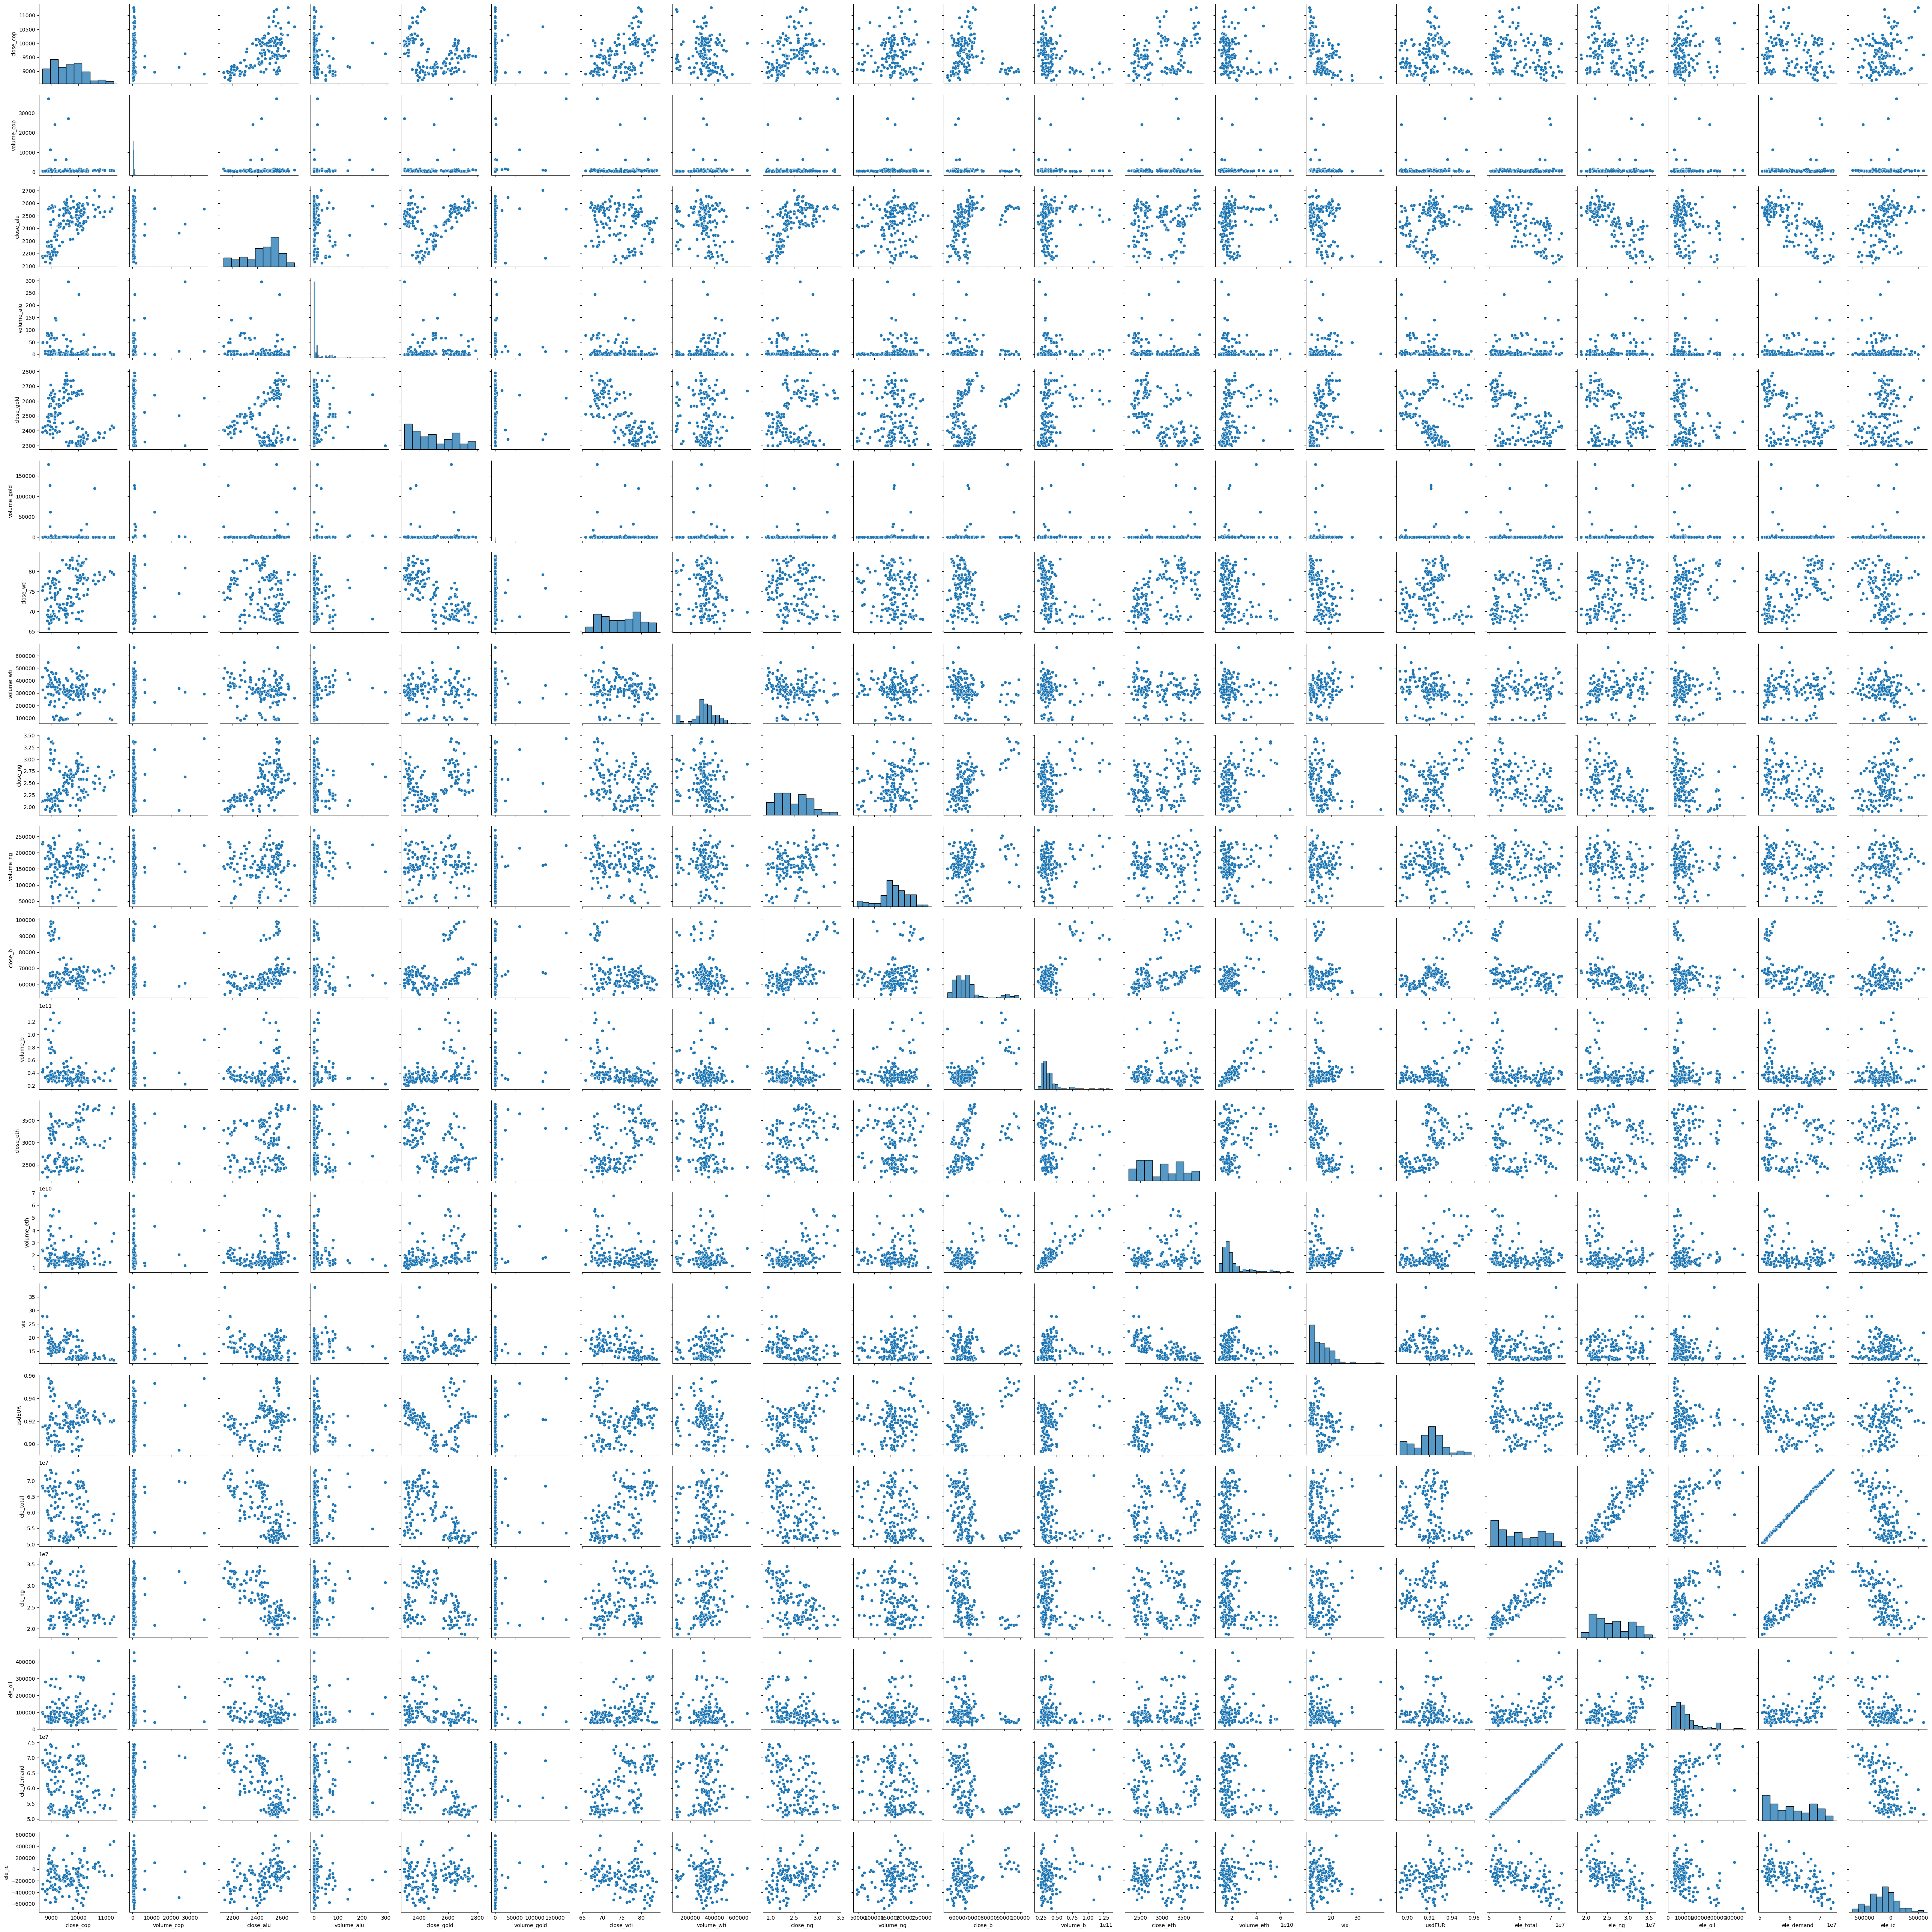

In [10]:
# Scatterplot Matrix (with all features)
sns.pairplot(df)
plt.show()

In [160]:
# Correlation Table
correlation_matrix = df.drop(columns=['Date']).corr()
correlation_matrix

close_cop  volume_cop  close_alu  volume_alu  close_gold  \
close_cop     1.000000   -0.114539   0.593136   -0.192247   -0.338596   
volume_cop   -0.114539    1.000000   0.034854    0.313887   -0.008546   
close_alu     0.593136    0.034854   1.000000   -0.175514    0.312465   
volume_alu   -0.192247    0.313887  -0.175514    1.000000    0.019944   
close_gold   -0.338596   -0.008546   0.312465    0.019944    1.000000   
volume_gold  -0.071214    0.524914   0.051000    0.009910   -0.011327   
close_wti     0.476649   -0.024161  -0.173510   -0.169760   -0.767413   
volume_wti   -0.117578   -0.009807  -0.161209    0.150809   -0.014146   
close_ng      0.219994    0.140952   0.631540   -0.086067    0.266974   
volume_ng     0.010424    0.077718   0.087759    0.124504    0.022599   
close_b      -0.136355    0.137220   0.429082   -0.130791    0.356281   
volume_b     -0.338758    0.110682   0.124977   -0.069916    0.362977   
close_eth     0.403985    0.080753   0.184344   -0.139388   -0.584287   
volume_eth   -0.226650    0.095203   0.114382   -0.094409    0.265017   
vix          -0.528285   -0.096937  -0.307586    0.110896    0.456339   
usdEUR        0.073107    0.173801   0.293754   -0.178642   -0.152730   
ele_total    -0.174194    0.057388  -0.712317    0.133247   -0.570096   
ele_ng       -0.315542    0.036052  -0.786223    0.174518   -0.386538   
ele_oil       0.174060    0.044891  -0.249332    0.012783   -0.301224   
ele_demand   -0.184843    0.054319  -0.717829    0.134204   -0.556701   
ele_ic        0.165328    0.032622   0.438829   -0.080418    0.171462   

             volume_gold  close_wti  volume_wti  close_ng  volume_ng  \
close_cop      -0.071214   0.476649   -0.117578  0.219994   0.010424   
volume_cop      0.524914  -0.024161   -0.009807  0.140952   0.077718   
close_alu       0.051000  -0.173510   -0.161209  0.631540   0.087759   
volume_alu      0.009910  -0.169760    0.150809 -0.086067   0.124504   
close_gold     -0.011327  -0.767413   -0.014146  0.266974   0.022599   
volume_gold     1.000000  -0.059586   -0.013314  0.126022   0.105844   
close_wti      -0.059586   1.000000   -0.119540 -0.257832  -0.164513   
volume_wti     -0.013314  -0.119540    1.000000 -0.113079  -0.067831   
close_ng        0.126022  -0.257832   -0.113079  1.000000   0.271338   
volume_ng       0.105844  -0.164513   -0.067831  0.271338   1.000000   
close_b         0.220309  -0.393864   -0.222848  0.678503   0.211314   
volume_b        0.131163  -0.451537   -0.008552  0.387921   0.215731   
close_eth       0.188568   0.498001   -0.170281  0.329655   0.042053   
volume_eth      0.123584  -0.337480    0.027893  0.400638   0.115910   
vix            -0.063719  -0.463391    0.279835 -0.256066   0.018123   
usdEUR          0.200377   0.146868   -0.234462  0.469459   0.139962   
ele_total      -0.034101   0.567647    0.108274 -0.463582  -0.207840   
ele_ng         -0.069102   0.411300    0.220051 -0.551075  -0.225524   
ele_oil        -0.066748   0.400127   -0.001783 -0.316878  -0.063842   
ele_demand     -0.036828   0.560055    0.113040 -0.465515  -0.209954   
ele_ic          0.084479  -0.261514   -0.162065  0.281853   0.229131   

              close_b  volume_b  close_eth  volume_eth       vix    usdEUR  \
close_cop   -0.136355 -0.338758   0.403985   -0.226650 -0.528285  0.073107   
volume_cop   0.137220  0.110682   0.080753    0.095203 -0.096937  0.173801   
close_alu    0.429082  0.124977   0.184344    0.114382 -0.307586  0.293754   
volume_alu  -0.130791 -0.069916  -0.139388   -0.094409  0.110896 -0.178642   
close_gold   0.356281  0.362977  -0.584287    0.265017  0.456339 -0.152730   
volume_gold  0.220309  0.131163   0.188568    0.123584 -0.063719  0.200377   
close_wti   -0.393864 -0.451537   0.498001   -0.337480 -0.463391  0.146868   
volume_wti  -0.222848 -0.008552  -0.170281    0.027893  0.279835 -0.234462   
close_ng     0.678503  0.387921   0.329655    0.400638 -0.256066  0.469459   
volume_ng    0.211314  0.215731   0.04205

In [161]:
def find_high_corr(correlation_matrix, threshold=0.6):

    high_corr_pairs = []

    for i in range(len(correlation_matrix.columns)):
        for j in range(i + 1, len(correlation_matrix.columns)):
            corr_value = correlation_matrix.iloc[i, j]
            if abs(corr_value) > threshold:
                high_corr_pairs.append((correlation_matrix.columns[i], correlation_matrix.columns[j], corr_value))

    if high_corr_pairs:
        print(f"Highly correlated variable pairs (|correlation| > {threshold}):")
        for var1, var2, corr in high_corr_pairs:
            print(f"{var1} and {var2}: {corr:.3f}")
    else:
        print(f"No pairs found with |correlation| > {threshold}.")

In [162]:
find_high_corr(correlation_matrix, threshold=0.6)

Highly correlated variable pairs (|correlation| > 0.6):
close_alu and close_ng: 0.632
close_alu and ele_total: -0.712
close_alu and ele_ng: -0.786
close_alu and ele_demand: -0.718
close_gold and close_wti: -0.767
close_ng and close_b: 0.679
close_b and volume_b: 0.689
close_b and volume_eth: 0.633
close_b and usdEUR: 0.670
volume_b and volume_eth: 0.909
close_eth and vix: -0.670
ele_total and ele_ng: 0.931
ele_total and ele_demand: 0.999
ele_total and ele_ic: -0.605
ele_ng and ele_demand: 0.938
ele_ng and ele_ic: -0.690
ele_demand and ele_ic: -0.619


In [163]:
df.columns

Index(['Date', 'close_cop', 'volume_cop', 'close_alu', 'volume_alu',
       'close_gold', 'volume_gold', 'close_wti', 'volume_wti', 'close_ng',
       'volume_ng', 'close_b', 'volume_b', 'close_eth', 'volume_eth', 'vix',
       'usdEUR', 'ele_total', 'ele_ng', 'ele_oil', 'ele_demand', 'ele_ic'],
      dtype='object')

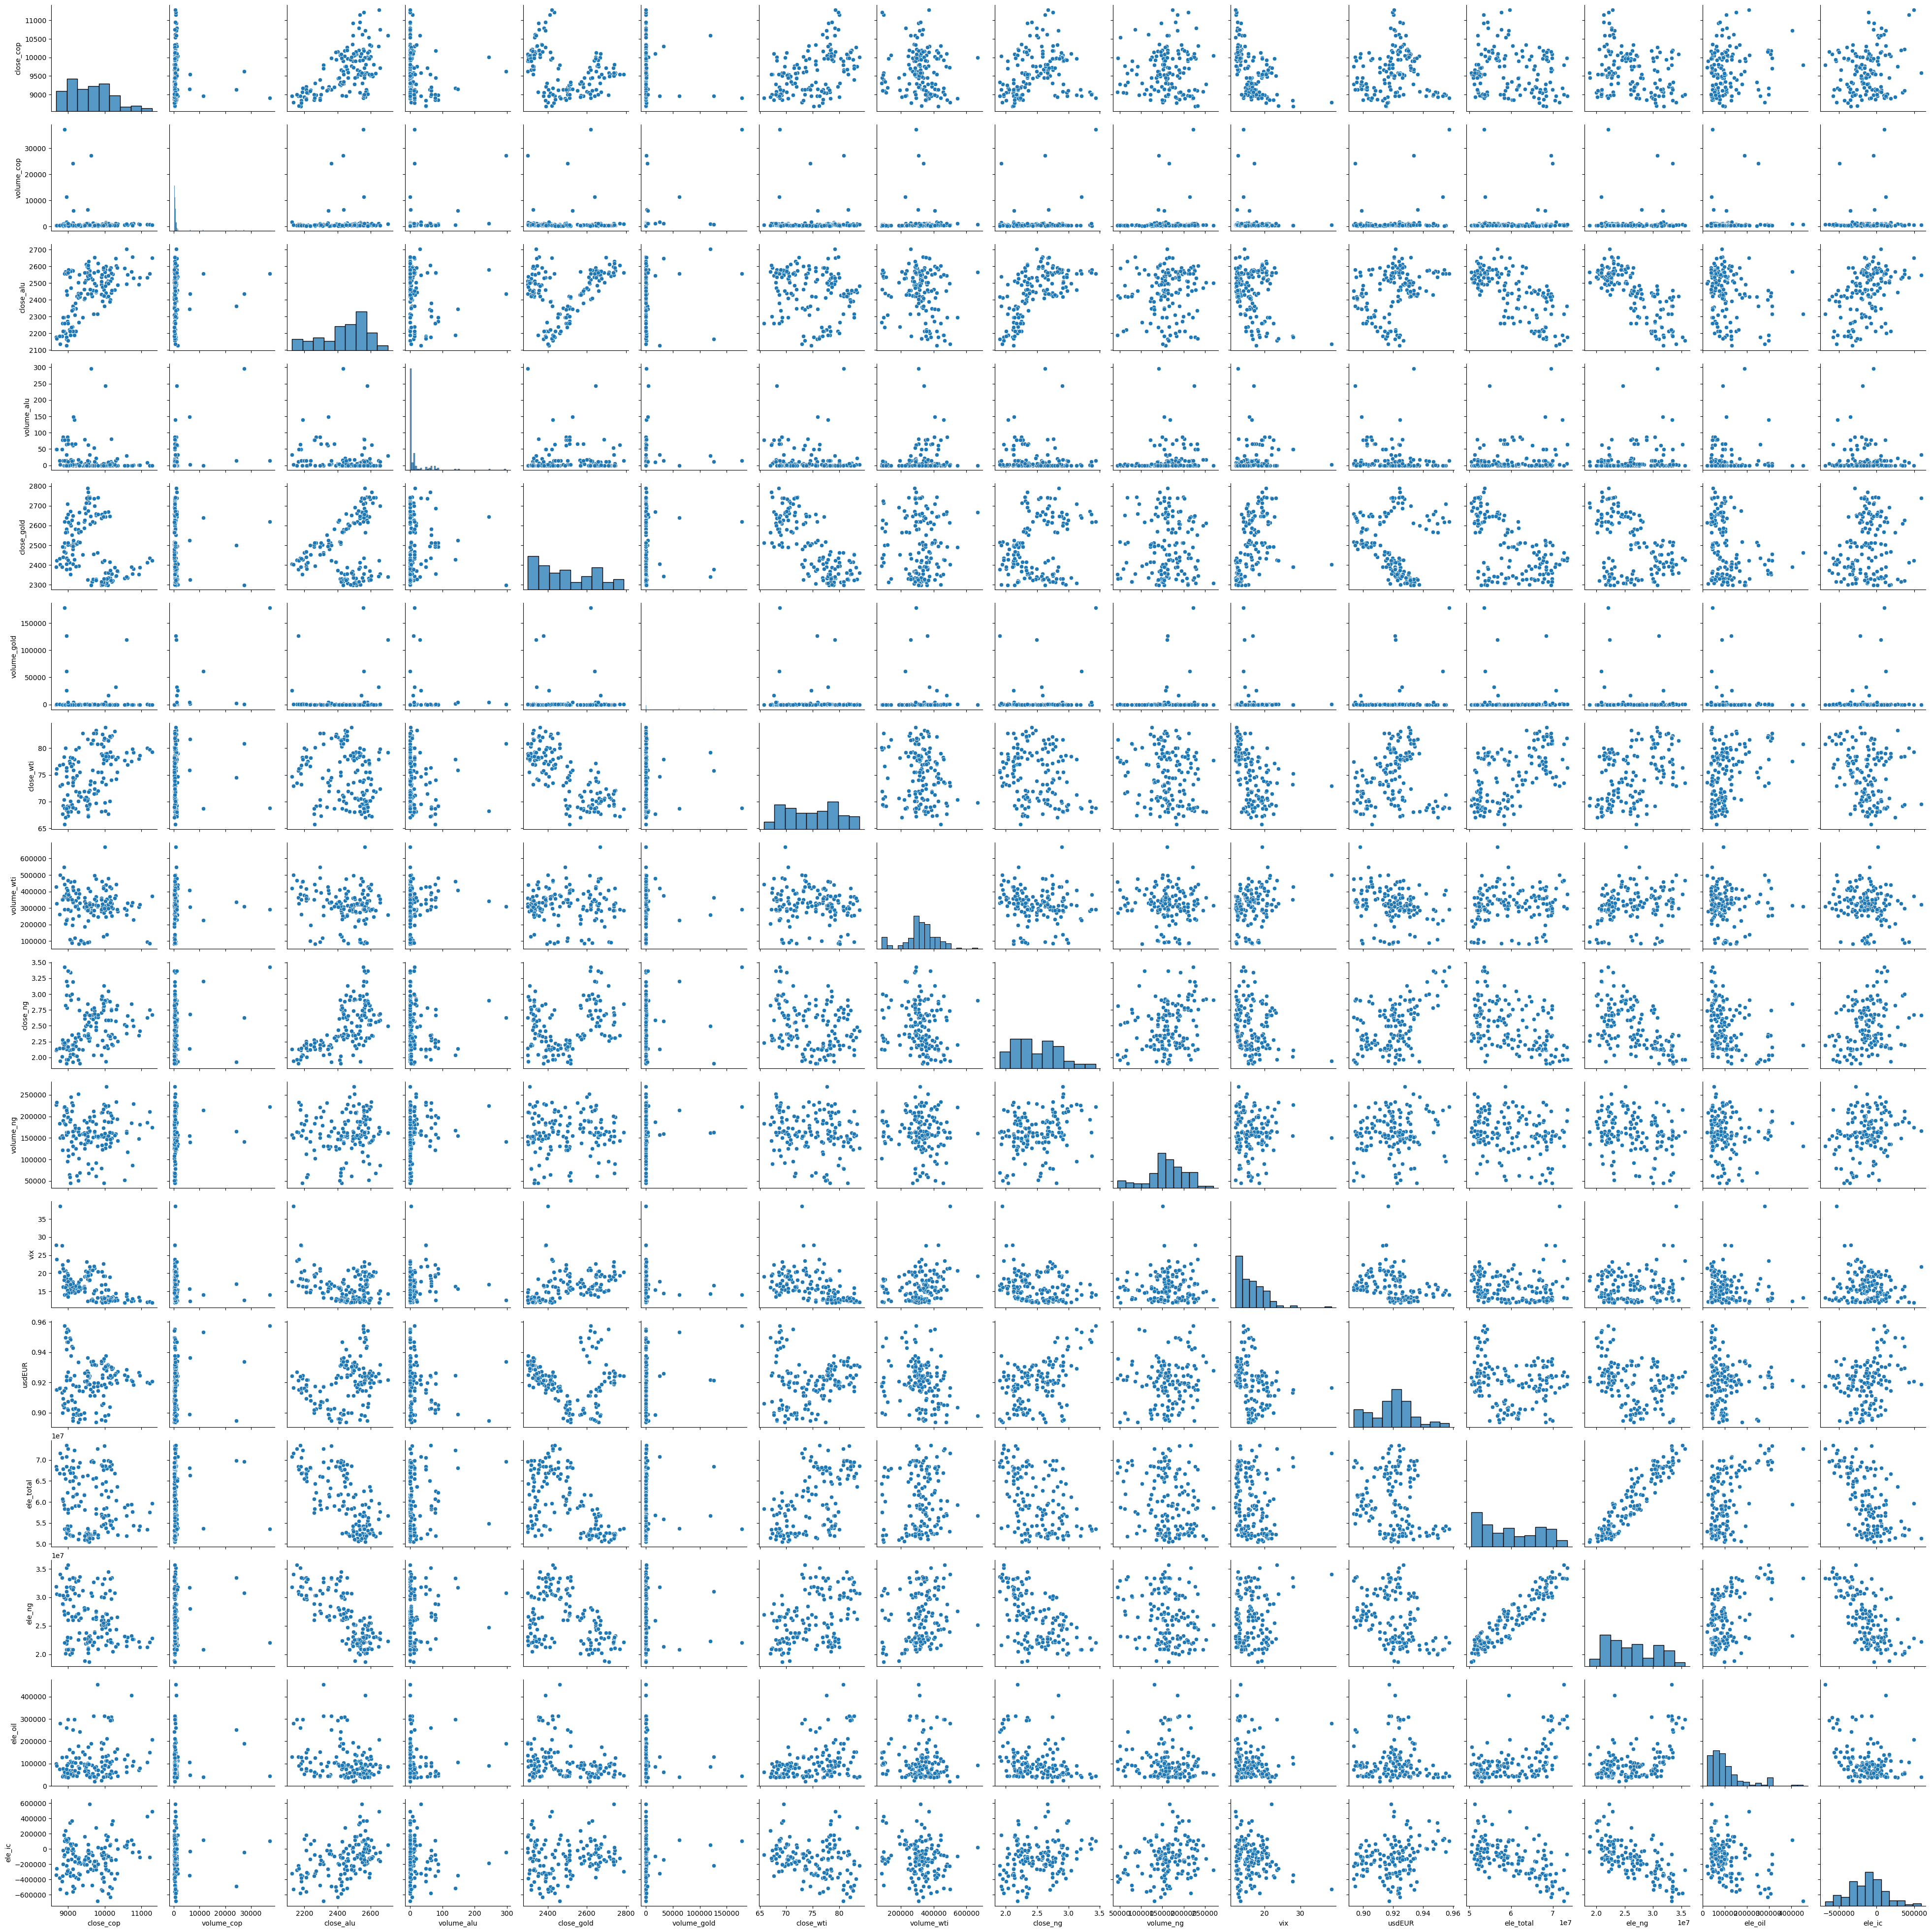

In [164]:
df_filtered = df.drop(columns=['close_b','close_eth','volume_b','volume_eth','ele_demand'])

# Scatterplot Matrix (with filtered features)
sns.pairplot(df_filtered)
plt.show()

In [165]:
# Correlation Table
correlation_matrix2 = df_filtered.drop(columns=['Date']).corr()
correlation_matrix2

close_cop  volume_cop  close_alu  volume_alu  close_gold  \
close_cop     1.000000   -0.114539   0.593136   -0.192247   -0.338596   
volume_cop   -0.114539    1.000000   0.034854    0.313887   -0.008546   
close_alu     0.593136    0.034854   1.000000   -0.175514    0.312465   
volume_alu   -0.192247    0.313887  -0.175514    1.000000    0.019944   
close_gold   -0.338596   -0.008546   0.312465    0.019944    1.000000   
volume_gold  -0.071214    0.524914   0.051000    0.009910   -0.011327   
close_wti     0.476649   -0.024161  -0.173510   -0.169760   -0.767413   
volume_wti   -0.117578   -0.009807  -0.161209    0.150809   -0.014146   
close_ng      0.219994    0.140952   0.631540   -0.086067    0.266974   
volume_ng     0.010424    0.077718   0.087759    0.124504    0.022599   
vix          -0.528285   -0.096937  -0.307586    0.110896    0.456339   
usdEUR        0.073107    0.173801   0.293754   -0.178642   -0.152730   
ele_total    -0.174194    0.057388  -0.712317    0.133247   -0.570096   
ele_ng       -0.315542    0.036052  -0.786223    0.174518   -0.386538   
ele_oil       0.174060    0.044891  -0.249332    0.012783   -0.301224   
ele_ic        0.165328    0.032622   0.438829   -0.080418    0.171462   

             volume_gold  close_wti  volume_wti  close_ng  volume_ng  \
close_cop      -0.071214   0.476649   -0.117578  0.219994   0.010424   
volume_cop      0.524914  -0.024161   -0.009807  0.140952   0.077718   
close_alu       0.051000  -0.173510   -0.161209  0.631540   0.087759   
volume_alu      0.009910  -0.169760    0.150809 -0.086067   0.124504   
close_gold     -0.011327  -0.767413   -0.014146  0.266974   0.022599   
volume_gold     1.000000  -0.059586   -0.013314  0.126022   0.105844   
close_wti      -0.059586   1.000000   -0.119540 -0.257832  -0.164513   
volume_wti     -0.013314  -0.119540    1.000000 -0.113079  -0.067831   
close_ng        0.126022  -0.257832   -0.113079  1.000000   0.271338   
volume_ng       0.105844  -0.164513   -0.067831  0.271338   1.000000   
vix            -0.063719  -0.463391    0.279835 -0.256066   0.018123   
usdEUR          0.200377   0.146868   -0.234462  0.469459   0.139962   
ele_total      -0.034101   0.567647    0.108274 -0.463582  -0.207840   
ele_ng         -0.069102   0.411300    0.220051 -0.551075  -0.225524   
ele_oil        -0.066748   0.400127   -0.001783 -0.316878  -0.063842   
ele_ic          0.084479  -0.261514   -0.162065  0.281853   0.229131   

                  vix    usdEUR  ele_total    ele_ng   ele_oil    ele_ic  
close_cop   -0.528285  0.073107  -0.174194 -0.315542  0.174060  0.165328  
volume_cop  -0.096937  0.173801   0.057388  0.036052  0.044891  0.032622  
close_alu   -0.307586  0.293754  -0.712317 -0.786223 -0.249332  0.438829  
volume_alu   0.110896 -0.178642   0.133247  0.174518  0.012783 -0.080418  
close_gold   0.456339 -0.152730  -0.570096 -0.386538 -0.301224  0.171462  
volume_gold -0.063719  0.200377  -0.034101 -0.069102 -0.066748  0.084479  
close_wti   -0.463391  0.146868   0.567647  0.411300  0.400127 -0.261514  
volume_wti   0.279835 -0.234462   0.108274  0.220051 -0.001783 -0.162065  
close_ng    -0.256066  0.469459  -0.463582 -0.551075 -0.316878  0.281853  
volume_ng    0.018123  0.139962  -0.207840 -0.225524 -0.063842  0.229131  
vix          1.000000 -0.314789  -0.072271  0.096791 -0.103421 -0.123586  
usdEUR      -0.314789  1.000000  -0.206103 -0.363641 -0.023447  0.247617  
ele_total   -0.072271 -0.206103   1.000000  0.931232  0.537021 -0.604790  
ele_ng       0.096791 -0.363641   0.931232  1.000000  0.495524 -0.689933  
ele_oil     -0.103421 -0.023447   0.537021  0.495524  1.000000 -0.367105  
ele_ic      -0.123586  0.247617  -0.604790 -0.689933 -0.367105  1.000000

In [166]:
# Find pairs with high correlation (absolute value > 0.6)
find_high_corr(correlation_matrix2, threshold=0.6)

Highly correlated variable pairs (|correlation| > 0.6):
close_alu and close_ng: 0.632
close_alu and ele_total: -0.712
close_alu and ele_ng: -0.786
close_gold and close_wti: -0.767
ele_total and ele_ng: 0.931
ele_total and ele_ic: -0.605
ele_ng and ele_ic: -0.690


## 2. Data Preprocessing
---
- Extract time-related variables from “date”
- Features Selection
- Data splitting and scaling

### Time-related variables

In [167]:
df_filtered[['year', 'month','day']] = df_filtered['Date'].str.split('-',expand=True)

df_filtered.head()

Date     close_cop  volume_cop  close_alu  volume_alu   close_gold  \
0  2024-05-01  10036.532045        1659    2537.75         0.0  2299.899902   
1  2024-05-02   9907.562187         864    2491.75         0.0  2299.199951   
2  2024-05-03  10082.829915         879    2512.25         0.0  2299.000000   
3  2024-05-06  10217.311449         642    2554.25         0.0  2321.600098   
4  2024-05-07  10197.470256         823    2527.00         1.0  2315.199951   

   volume_gold  close_wti  volume_wti  close_ng  volume_ng    vix   usdEUR  \
0         42.0  79.000000    441978.0     1.932     135918  15.39  0.93751   
1         56.0  78.949997    359652.0     2.035     153739  14.68  0.93270   
2        194.0  78.110001    324438.0     2.142     209456  13.49  0.93170   
3          9.0  78.480003    297369.0     2.195     196381  13.49  0.92953   
4         25.0  78.379997    327593.0     2.207     149430  13.23  0.92872   

   ele_total    ele_ng  ele_oil  ele_ic  year month day  
0   53785516  21637669   112706  184028  2024    05  01  
1   54281449  23096113   193433    7610  2024    05  02  
2   52849224  22425534   136459  164868  2024    05  03  
3   53736558  20512576    59625  368525  2024    05  06  
4   55390304  22049630   111337  322964  2024    05  07

In [168]:
df_filtered[['year', 'month','day']] = df_filtered[['year', 'month','day']].astype('int')
df_model = df_filtered.drop('Date', axis=1)
df_model.head()

close_cop  volume_cop  close_alu  volume_alu   close_gold  volume_gold  \
0  10036.532045        1659    2537.75         0.0  2299.899902         42.0   
1   9907.562187         864    2491.75         0.0  2299.199951         56.0   
2  10082.829915         879    2512.25         0.0  2299.000000        194.0   
3  10217.311449         642    2554.25         0.0  2321.600098          9.0   
4  10197.470256         823    2527.00         1.0  2315.199951         25.0   

   close_wti  volume_wti  close_ng  volume_ng    vix   usdEUR  ele_total  \
0  79.000000    441978.0     1.932     135918  15.39  0.93751   53785516   
1  78.949997    359652.0     2.035     153739  14.68  0.93270   54281449   
2  78.110001    324438.0     2.142     209456  13.49  0.93170   52849224   
3  78.480003    297369.0     2.195     196381  13.49  0.92953   53736558   
4  78.379997    327593.0     2.207     149430  13.23  0.92872   55390304   

     ele_ng  ele_oil  ele_ic  year  month  day  
0  21637669   112706  184028  2024      5    1  
1  23096113   193433    7610  2024      5    2  
2  22425534   136459  164868  2024      5    3  
3  20512576    59625  368525  2024      5    6  
4  22049630   111337  322964  2024      5    7

In [169]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148 entries, 0 to 147
Data columns (total 19 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   close_cop    148 non-null    float64
 1   volume_cop   148 non-null    int64  
 2   close_alu    148 non-null    float64
 3   volume_alu   148 non-null    float64
 4   close_gold   148 non-null    float64
 5   volume_gold  148 non-null    float64
 6   close_wti    148 non-null    float64
 7   volume_wti   148 non-null    float64
 8   close_ng     148 non-null    float64
 9   volume_ng    148 non-null    int64  
 10  vix          148 non-null    float64
 11  usdEUR       148 non-null    float64
 12  ele_total    148 non-null    int64  
 13  ele_ng       148 non-null    int64  
 14  ele_oil      148 non-null    int64  
 15  ele_ic       148 non-null    int64  
 16  year         148 non-null    int64  
 17  month        148 non-null    int64  
 18  day          148 non-null    int64  
dtypes: float

In [170]:
df_model.columns

Index(['close_cop', 'volume_cop', 'close_alu', 'volume_alu', 'close_gold',
       'volume_gold', 'close_wti', 'volume_wti', 'close_ng', 'volume_ng',
       'vix', 'usdEUR', 'ele_total', 'ele_ng', 'ele_oil', 'ele_ic', 'year',
       'month', 'day'],
      dtype='object')

### Features Selection

In [171]:
# Feature selection
features = ['close_gold','volume_gold','volume_wti', 'close_ng', 'volume_ng',
       'vix', 'usdEUR', 'ele_oil', 'ele_ic',
       'month', 'day']

X = df_model[features]
y = df_model["close_wti"]

### Data Splitting & Scaling

In [242]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle = False)

In [243]:
# Apply MinMax scaling
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert scaled data back to DataFrame for consistency
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=features)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=features)

## 3. Multiple Regression Model (Initial Overview)
---
- **Models**
	1.	With “year, month, day” variables
	2.	Without time-related variables
- **Note**
  - Same features as selected in Section 2 (Data Preprocessing)


In [244]:
formula1 = 'close_wti ~ close_gold + volume_gold + volume_wti + close_ng + volume_ng + vix + usdEUR + ele_oil + ele_ic'

model1 = ols(formula1, data=df_model).fit()

print(model1.summary())

                            OLS Regression Results                            
Dep. Variable:              close_wti   R-squared:                       0.681
Model:                            OLS   Adj. R-squared:                  0.661
Method:                 Least Squares   F-statistic:                     32.81
Date:                Sun, 02 Feb 2025   Prob (F-statistic):           3.65e-30
Time:                        11:09:05   Log-Likelihood:                -356.97
No. Observations:                 148   AIC:                             733.9
Df Residuals:                     138   BIC:                             763.9
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept     110.9968     20.096      5.523      

In [245]:
formula2 = 'close_wti ~ close_gold + volume_gold + volume_wti + close_ng + volume_ng + vix + usdEUR + ele_oil + ele_ic  + year + month + day'

model2 = ols(formula2, data=df_model).fit()

print(model2.summary())

                            OLS Regression Results                            
Dep. Variable:              close_wti   R-squared:                       0.725
Model:                            OLS   Adj. R-squared:                  0.703
Method:                 Least Squares   F-statistic:                     32.66
Date:                Sun, 02 Feb 2025   Prob (F-statistic):           6.58e-33
Time:                        11:09:06   Log-Likelihood:                -345.99
No. Observations:                 148   AIC:                             716.0
Df Residuals:                     136   BIC:                             752.0
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept    1.348e-05   5.68e-06      2.371      

## 4. Model Performance Comparison
---
- **4.1 Multiple Regression Model**
    - **4.1.1** Assumption Checks
    - **4.1.2** Influence Analysis
    - **4.1.3** Cleaned model (excluding influential points based on studentized residuals)
- **4.2 XGBoost**
    - **Model 1**: Hyperparameter tuning to identify optimal model
    - **Model 2**: No hyperparameter tuning
    - **Model 3**: Self-adjusted hyperparameters
- **4.3 LSTM**

### 4.1 Multiple Regression Model

In [246]:
X_train_scaled_df = sm.add_constant(X_train_scaled_df)

X_test_scaled_df['const'] = 1
X_test_scaled_df = X_test_scaled_df[['const'] + list(X_test_scaled_df.columns[:-1])]

In [247]:
y_train_reset = y_train.reset_index(drop=True)
X_train_scaled_df_reset = X_train_scaled_df.reset_index(drop=True)

In [248]:
regression_model = sm.OLS(y_train_reset, X_train_scaled_df_reset).fit()

In [249]:
y_pred_reg = regression_model.predict(X_test_scaled_df)

In [250]:
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_reg))
print(f'Test RMSE: {test_rmse:.4f}')

Test RMSE: 5.7173


In [251]:
print(regression_model.summary())

                            OLS Regression Results                            
Dep. Variable:              close_wti   R-squared:                       0.743
Model:                            OLS   Adj. R-squared:                  0.711
Method:                 Least Squares   F-statistic:                     23.86
Date:                Sun, 02 Feb 2025   Prob (F-statistic):           3.01e-22
Time:                        11:09:13   Log-Likelihood:                -226.62
No. Observations:                 103   AIC:                             477.2
Df Residuals:                      91   BIC:                             508.8
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          78.7887      2.414     32.643      

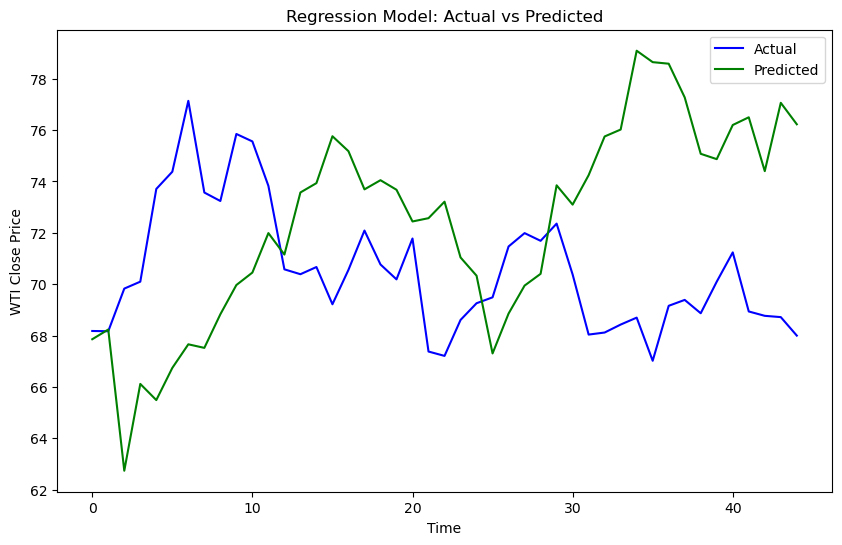

In [252]:
y_test_reset = y_test.reset_index(drop=True)

plt.figure(figsize=(10, 6))
plt.plot(y_test_reset, label='Actual', color='blue')
plt.plot(y_pred_reg, label='Predicted', color='green')
plt.title('Regression Model: Actual vs Predicted')
plt.xlabel('Time')
plt.ylabel('WTI Close Price')
plt.legend()
plt.show()

### 4.1.1 Assumption Checks
---
- **Homoskedasticity**: ...
- **Serial Correlation**: ...
- **Multicollinearity**:
    - ...


eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1


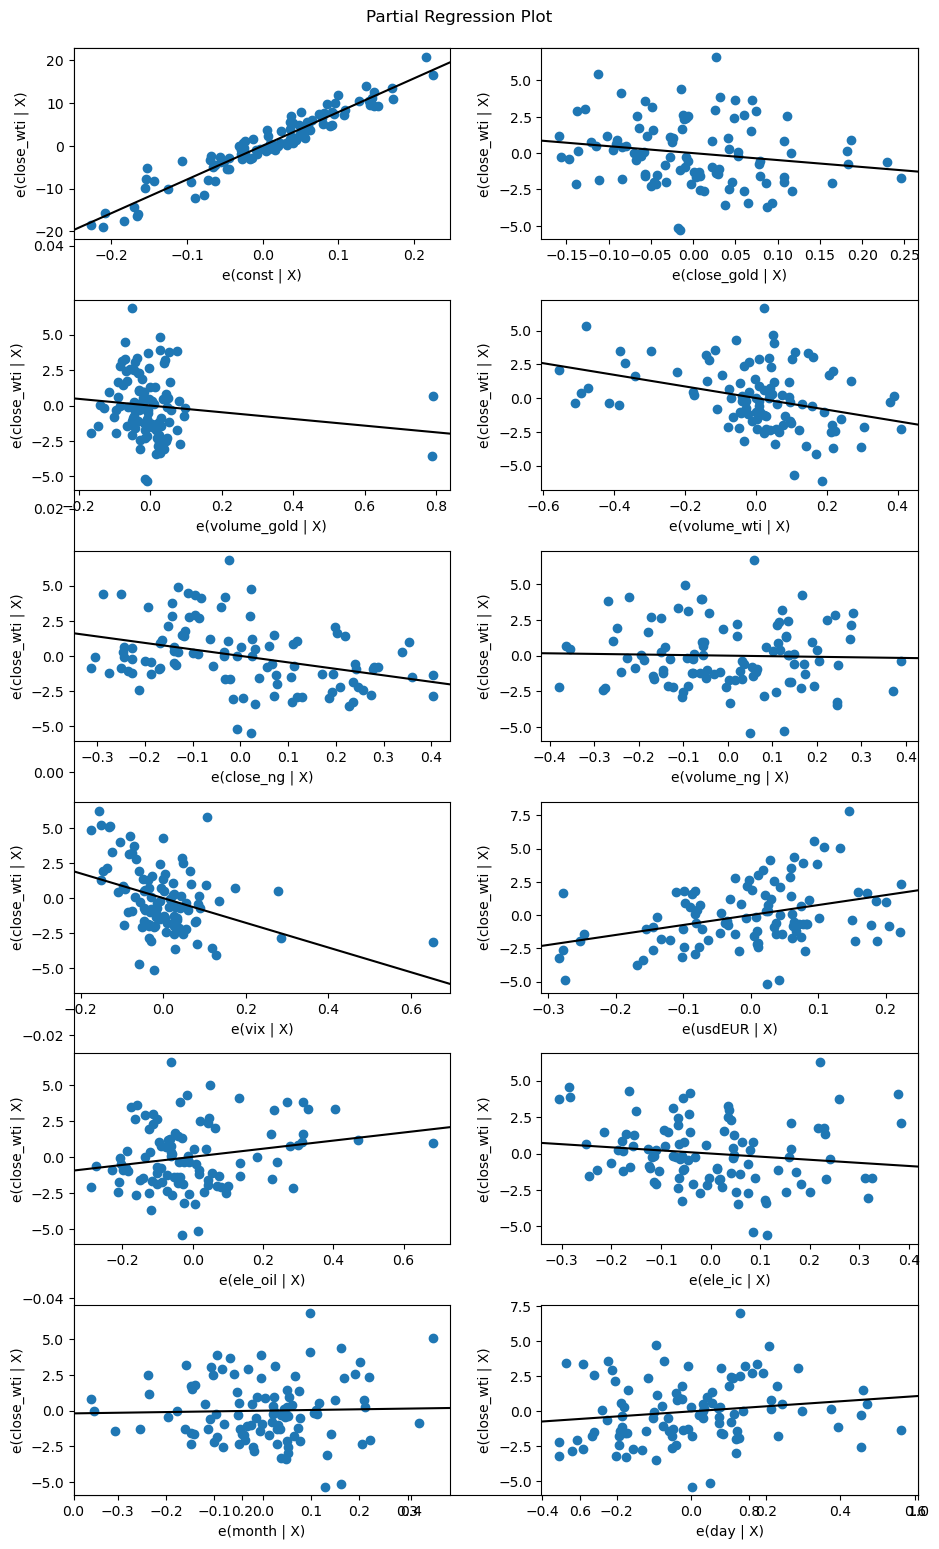

In [253]:
# Residual Analysis

fig, ax = plt.subplots(figsize=(10,16))

fig = sm.graphics.plot_partregress_grid(regression_model, fig=fig)

for ax in fig.axes:
    ax.autoscale(enable=True, axis='y')

fig.tight_layout(pad=2.0, h_pad=2.0, w_pad=2.0)

plt.show()

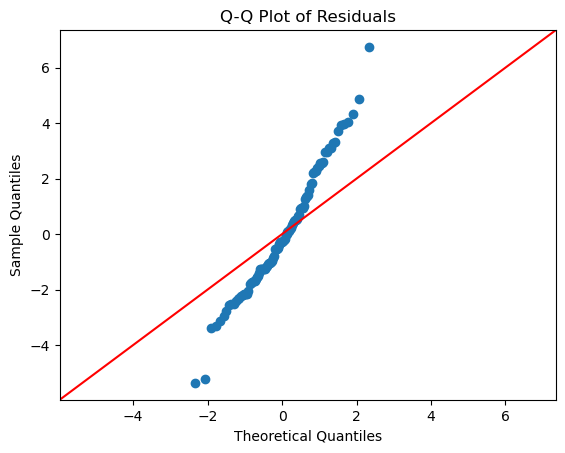

In [254]:
# Q-Q plot
sm.qqplot(regression_model.resid, line='45')
plt.title("Q-Q Plot of Residuals")
plt.show()

In [255]:
# Perform the BP test - Homoskedasticity

bp_test = het_breuschpagan(regression_model.resid, regression_model.model.exog)

bp_stat = bp_test[0]
bp_p_value = bp_test[1]

print("\nBreusch-Pagan test for heteroskedasticity:")
print(f"Test Statistic: {bp_stat:.4f}")
print(f"P-value: {bp_p_value:.4f}")

if bp_p_value < 0.05:
    print("Heteroskedasticity detected (reject null hypothesis).")
else:
    print("No significant heteroskedasticity detected (fail to reject null hypothesis).")


Breusch-Pagan test for heteroskedasticity:
Test Statistic: 24.2519
P-value: 0.0117
Heteroskedasticity detected (reject null hypothesis).


In [256]:
# Perform the BG test for autocorrelation
bg_test = acorr_breusch_godfrey(regression_model, nlags=1)

print("\nBreusch-Godfrey test for autocorrelation:")
print(f"Test Statistic: {bg_test[0]:.4f}")
print(f"P-value: {bg_test[1]:.4f}")

if bg_test[1] < 0.05:
    print("Autocorrelation detected (reject null hypothesis).")
else:
    print("No significant autocorrelation detected (fail to reject null hypothesis).")


Breusch-Godfrey test for autocorrelation:
Test Statistic: 37.6871
P-value: 0.0000
Autocorrelation detected (reject null hypothesis).


In [257]:
# Perform VIF for multicollinearity
variables = df_model[features]

vif_data = pd.DataFrame()
vif_data['Variable'] = variables.columns
vif_data['VIF'] = [variance_inflation_factor(variables.values, i) for i in range(variables.shape[1])]

vif_data

Variable          VIF
0    close_gold  1354.720371
1   volume_gold     1.248844
2    volume_wti    13.194334
3      close_ng    94.289186
4     volume_ng    19.214697
5           vix    38.550132
6        usdEUR   927.251193
7       ele_oil     3.979410
8        ele_ic     1.757855
9         month    91.835797
10          day     7.163156

### 4.1.2 Influence Analysis

In [258]:
influence = regression_model.get_influence()

influence_summary = influence.summary_frame()
influence_summary

dfb_const  dfb_close_gold  dfb_volume_gold  dfb_volume_wti  dfb_close_ng  \
0    -0.003662       -0.096990        -0.002888       -0.088630      0.128356   
1    -0.101051       -0.052897        -0.016782       -0.035115      0.132957   
2    -0.049421       -0.011027         0.028475       -0.013433      0.178945   
3    -0.005965       -0.010881         0.015104        0.005772      0.055693   
4    -0.030285        0.010703         0.003233       -0.008177      0.043144   
..         ...             ...              ...             ...           ...   
98   -0.018906        0.078645         0.006017       -0.001025      0.037646   
99   -0.011741        0.034422         0.007354        0.009519      0.040082   
100  -0.014519        0.072770         0.017392        0.004961      0.041573   
101  -0.056235        0.208772         0.041562        0.192217      0.177893   
102   0.066689       -0.081235        -0.021218       -0.059883     -0.026621   

     dfb_volume_ng   dfb_vix  dfb_usdEUR  dfb_ele_oil  dfb_ele_ic  dfb_month  \
0         0.077104  0.012272   -0.100080     0.039515   -0.045518   0.085889   
1         0.077448  0.022845   -0.009175    -0.042972   -0.015867   0.119561   
2        -0.076037  0.059042   -0.011404     0.007609   -0.059416   0.073983   
3        -0.015850  0.006188   -0.013555     0.024394   -0.046462   0.024972   
4         0.050671  0.014425    0.012120    -0.018879   -0.089568   0.021159   
..             ...       ...         ...          ...         ...        ...   
98        0.007302 -0.000772    0.011772    -0.011060   -0.017182  -0.025371   
99       -0.021192  0.006654    0.005546     0.000431   -0.001571  -0.009414   
100      -0.058623  0.010968    0.037599    -0.009609   -0.011376  -0.024583   
101      -0.141032  0.005119    0.036192    -0.029055   -0.040758  -0.107588   
102      -0.024810  0.004189   -0.049460     0.014764    0.008428   0.023120   

      dfb_day   cooks_d  standard_resid  hat_diag  dffits_internal  \
0    0.117002  0.007864       -0.706580  0.158975        -0.307200   
1    0.170538  0.009211       -1.012562  0.097319        -0.332471   
2    0.078054  0.009699       -1.133367  0.083079        -0.341154   
3    0.015857  0.001347       -0.395076  0.093847        -0.127142   
4    0.051834  0.002531       -0.561187  0.087952        -0.174270   
..        ...       ...             ...       ...              ...   
98  -0.012621  0.002226        0.608576  0.067272         0.163438   
99  -0.010062  0.000520        0.242836  0.095714         0.079004   
100 -0.032181  0.001100        0.246824  0.178067         0.114884   
101 -0.080787  0.014269        0.864156  0.186529         0.413803   
102 -0.010632  0.001403       -0.252726  0.208552        -0.129732   

     student_resid    dffits  
0        -0.704623 -0.306349  
1        -1.012705 -0.332518  
2        -1.135163 -0.341695  
3        -0.393236 -0.126550  
4        -0.559064 -0.173610  
..             ...       ...  
98        0.606458  0.162869  
99        0.241577  0.078594  
100       0.245547  0.114290  
101       0.862943  0.413222  
102      -0.251422 -0.129062  

[103 rows x 18 columns]

In [259]:
# High leverage points
k = regression_model.df_model
n = regression_model.nobs
threshold = 3 * ((k + 1) / n)

influence_summary[influence_summary['hat_diag'] > threshold]

dfb_const  dfb_close_gold  dfb_volume_gold  dfb_volume_wti  dfb_close_ng  \
19   0.210826       -0.014110         1.350710       -0.156055      0.237058   
60   0.028176        0.078186        -0.990093        0.010199      0.147303   
65  -0.059753        0.125679        -0.003838       -0.023815      0.437053   

    dfb_volume_ng   dfb_vix  dfb_usdEUR  dfb_ele_oil  dfb_ele_ic  dfb_month  \
19      -0.190424  0.134521   -0.206221     0.057684    0.049322  -0.165928   
60      -0.014951  0.128817   -0.051923    -0.038934   -0.019743  -0.168599   
65      -0.231157  1.408135   -0.003949     0.305673   -0.065157  -0.405732   

     dfb_day   cooks_d  standard_resid  hat_diag  dffits_internal  \
19 -0.218888  0.180565        1.526576  0.481806         1.472001   
60 -0.000531  0.107706       -1.080372  0.525465        -1.136870   
65 -0.130821  0.206495        1.585679  0.496350         1.574146   

    student_resid    dffits  
19       1.537986  1.483003  
60      -1.081377 -1.137928  
65       1.599190  1.587559

In [260]:
# Studentized Residuals
alpha = 0.05 

Df = n - k - 1

t_critical = t.ppf(1 - alpha/2, Df)

influence_summary[abs(influence_summary['student_resid'])>t_critical ]

dfb_const  dfb_close_gold  dfb_volume_gold  dfb_volume_wti  dfb_close_ng  \
41  -0.281887       -0.335005         0.052836        0.063978      0.032538   
70  -0.520667        0.103455        -0.131845        0.037464     -0.043495   
90   0.200681        0.045595         0.018608       -0.242167     -0.029470   
91   0.226599        0.051925         0.027880       -0.134181      0.009290   

    dfb_volume_ng   dfb_vix  dfb_usdEUR  dfb_ele_oil  dfb_ele_ic  dfb_month  \
41      -0.145285 -0.379903    0.207865     0.072137    0.634091   0.680383   
70       0.115378  0.336153    0.415033    -0.116712    0.477878   0.245644   
90      -0.073813  0.052811   -0.053653     0.043133   -0.187238  -0.246577   
91      -0.182467  0.133865   -0.088401    -0.022536   -0.135747  -0.297563   

     dfb_day   cooks_d  standard_resid  hat_diag  dffits_internal  \
41 -0.118639  0.081351        2.286046  0.157397         0.988032   
70  0.215186  0.060677        3.018160  0.074016         0.853304   
90 -0.003867  0.027220       -2.376175  0.054687        -0.571519   
91 -0.062251  0.023780       -2.310779  0.050729        -0.534187   

    student_resid    dffits  
41       2.341685  1.012079  
70       3.164071  0.894556  
90      -2.439991 -0.586869  
91      -2.368589 -0.547551

In [261]:
# Cook's Distance
cook_d_threshold = np.sqrt(k / n)

influence_summary[influence_summary['cooks_d'] > cook_d_threshold]

Empty DataFrame
Columns: [dfb_const, dfb_close_gold, dfb_volume_gold, dfb_volume_wti, dfb_close_ng, dfb_volume_ng, dfb_vix, dfb_usdEUR, dfb_ele_oil, dfb_ele_ic, dfb_month, dfb_day, cooks_d, standard_resid, hat_diag, dffits_internal, student_resid, dffits]
Index: []

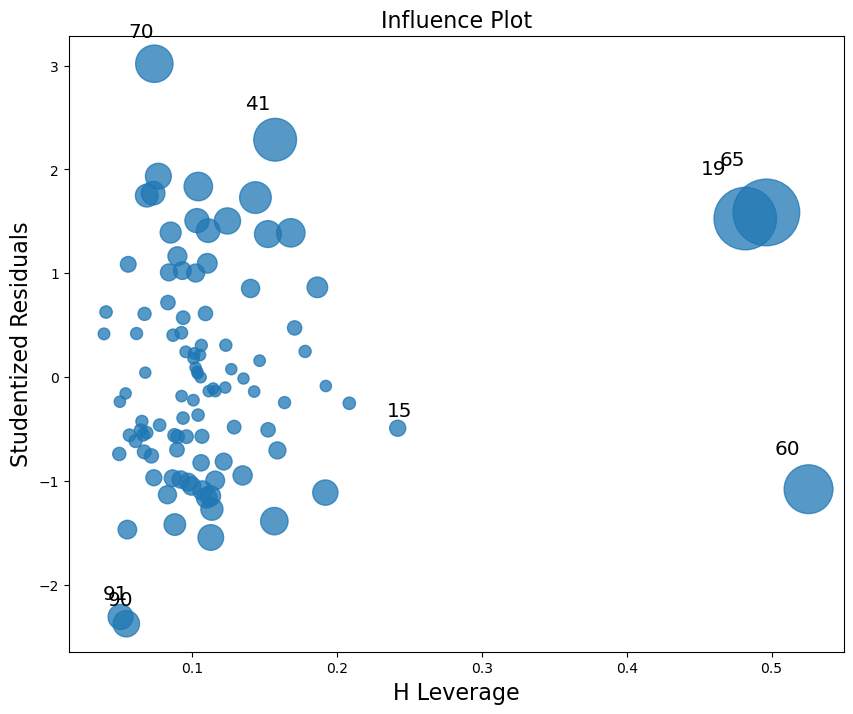

In [262]:
fig, ax = plt.subplots(figsize=(10, 8))
influence.plot_influence(ax=ax)

plt.show()

### 4.1.3 Cleaned model (excluding influential points based on studentized residuals)

In [263]:
influential_points = influence_summary[abs(influence_summary['student_resid']) > t_critical]

train_data_cleaned = X_train_scaled_df_reset.drop(influential_points.index)
y_train_cleaned = y_train_reset.drop(influential_points.index)

regression_model_cleaned = sm.OLS(y_train_cleaned, train_data_cleaned).fit()

y_pred_cleaned = regression_model_cleaned.predict(X_test_scaled_df)

print(regression_model_cleaned.summary())

                            OLS Regression Results                            
Dep. Variable:              close_wti   R-squared:                       0.781
Model:                            OLS   Adj. R-squared:                  0.753
Method:                 Least Squares   F-statistic:                     28.20
Date:                Sun, 02 Feb 2025   Prob (F-statistic):           4.10e-24
Time:                        11:09:48   Log-Likelihood:                -204.33
No. Observations:                  99   AIC:                             432.7
Df Residuals:                      87   BIC:                             463.8
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          79.6629      2.181     36.521      

In [264]:
rmse_cleaned = np.sqrt(mean_squared_error(y_test, y_pred_cleaned))

print(f"RMSE for the cleaned model: {rmse_cleaned:.4f}")

RMSE for the cleaned model: 5.1298


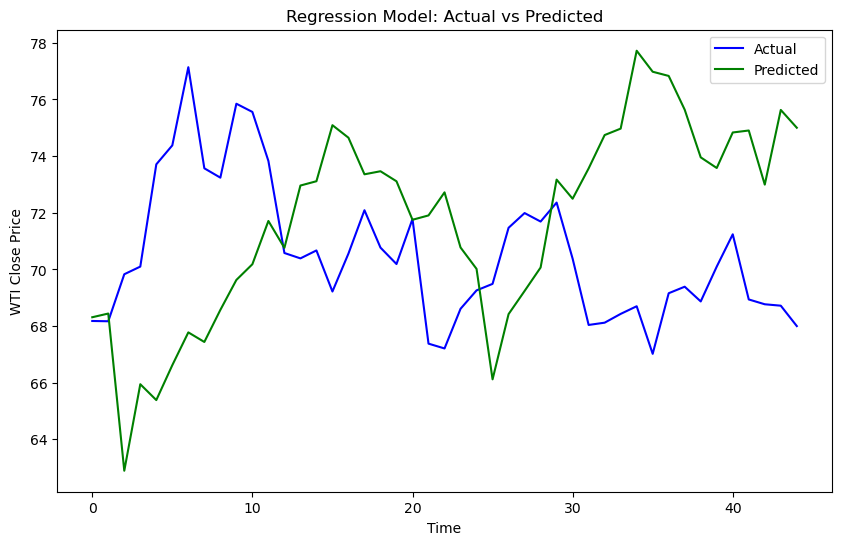

In [265]:
y_test_reset = y_test.reset_index(drop=True)

plt.figure(figsize=(10, 6))
plt.plot(y_test_reset, label='Actual', color='blue')
plt.plot(y_pred_cleaned, label='Predicted', color='green')
plt.title('Regression Model: Actual vs Predicted')
plt.xlabel('Time')
plt.ylabel('WTI Close Price')
plt.legend()
plt.show()

## 4.2 XGBoost
---

In [266]:
def adjusted_r2(r2, n, p):
    return 1 - (1 - r2) * (n - 1) / (n - p - 1)

### Model 1: Hyperparameter tuning to identify optimal model

In [267]:
# Define the XGBoost model
xgb_model = xgb.XGBRegressor(random_state=42)

# xgb_model = xgb.XGBRegressor()

In [268]:
tscv = TimeSeriesSplit(n_splits=5)

In [269]:
param_grid = {
    'n_estimators': [30, 40, 45, 50],  # You can experiment with reducing this further
    'max_depth': [2, 3, 4, 5],  # A shallower tree depth helps generalize better
    'learning_rate': [0.01, 0.05, 0.1],  # Lower learning rate forces the model to learn more slowly
    'reg_alpha': [0, 0.1, 0.5, 1],  # L1 regularization (reduce model complexity)
    'reg_lambda': [1, 2, 3, 4],  # L2 regularization (reduces overfitting)
    'subsample': [0.6, 0.7, 0.8, 0.9],  # Fraction of samples used for training each tree
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9],  # Fraction of features used per tree
    #'min_child_weight': [1, 2, 3],  # Controls overfitting by specifying minimum sum of instance weight
}

# param_grid = {
#     'n_estimators': [30,40,45,50,55],
#     'max_depth': [2,3,4,5],
#     'learning_rate': [0.01, 0.1, 0.3],
#     'reg_alpha': [0, 0.1, 1],
#     'reg_lambda': [1,2,3,4,5,6,7]
# }


grid_search = GridSearchCV(estimator=xgb_model,
                           param_grid=param_grid,
                           cv=tscv,
                           scoring='r2',
                           n_jobs=-1,
                           verbose=1)

In [270]:
grid_search.fit(X_train_scaled_df, y_train)

Fitting 5 folds for each of 12288 candidates, totalling 61440 fits


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None, gpu_id=None,
                                    grow_policy=None, imp...
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, random_state=42, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.6, 0.7, 0.8, 0.9],
                         'learning_rate': [0.01, 0.05, 0.1],
                         'max_depth': [2, 3, 4, 5],
                         'n_estimators': [30, 40, 45, 50],
                         'reg_alpha': [0, 0.1, 0.5, 1],
                         'reg_lambda': [1, 2, 3, 4],
                         'subsample': [0.6, 0.7, 0.8, 0.9]},
             scoring='r2', verbose=1)

In [271]:
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print("Best Hyperparameters:", best_params)

Best Hyperparameters: {'colsample_bytree': 0.6, 'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 50, 'reg_alpha': 0.1, 'reg_lambda': 2, 'subsample': 0.9}


In [272]:
y_train_pred = best_model.predict(X_train_scaled_df)
train_mse = mean_squared_error(y_train, y_train_pred)
train_rmse = np.sqrt(train_mse)
train_r2 = r2_score(y_train, y_train_pred)


y_test_pred = best_model.predict(X_test_scaled_df)
test_mse = mean_squared_error(y_test, y_test_pred)
test_rmse = np.sqrt(test_mse)
test_r2 = r2_score(y_test, y_test_pred)


train_adj_r2 = adjusted_r2(train_r2, len(X_train), X_train.shape[1])
test_adj_r2 = adjusted_r2(test_r2, len(X_test), X_test.shape[1])


print(f"Model Performance (Training Set)")
print(f"-------------------------------------")
print(f"Training MSE: {round(train_mse,3)}")
print(f"Training RMSE: {round(train_rmse,3)}")
print(f"Training R-squared: {round(train_r2,3)}")
print(f"Training Adjusted R-squared: {round(train_adj_r2,3)}")

print(f"\nModel Performance (Testing Set)")
print(f"-------------------------------------")
print(f"Testing MSE: {round(test_mse,3)}")
print(f"Testing RMSE: {round(test_rmse,3)}")
print(f"Testing R-squared: {round(test_r2,3)}")
print(f"Testing Adjusted R-squared: {round(test_adj_r2,3)}")

# Overfitting
# r2_diff = train_r2 - test_r2

# if r2_diff > 0.1:
#     print(f"\n")
#     print(f"\nOverfitting Check(Based on R-squred)")
#     print(f"-------------------------------------")
#     print(f"Potential overfitting detected: Training R-squared is higher than Testing R-squared by {r2_diff:.4f}")
# else:
#     print("\nNo significant overfitting detected.")


# adj_r2_diff = train_adj_r2 - test_adj_r2

# if adj_r2_diff > 0.1:
#     print(f"\nOverfitting Check(Based on Adjustd R-squred)")
#     print(f"-------------------------------------")
#     print(f"Potential overfitting detected: Training Adjusted R-squared is higher than Testing Adjusted R-squared by {adj_r2_diff:.4f}")
# else:
#     print("\nNo significant overfitting detected.")

Model Performance (Training Set)
-------------------------------------
Training MSE: 2.432
Training RMSE: 1.56
Training R-squared: 0.869
Training Adjusted R-squared: 0.853

Model Performance (Testing Set)
-------------------------------------
Testing MSE: 8.849
Testing RMSE: 2.975
Testing R-squared: -0.553
Testing Adjusted R-squared: -1.07


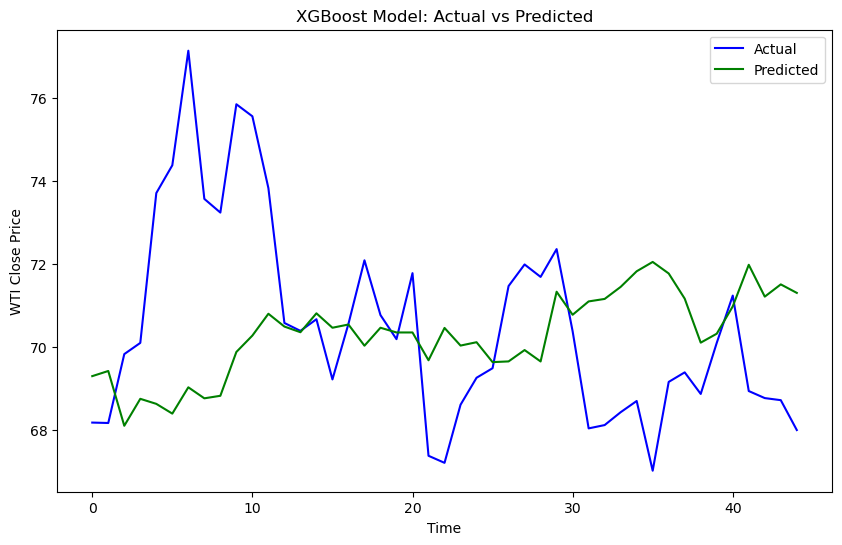

In [273]:
# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(y_test_reset, label='Actual', color='blue')
plt.plot(y_test_pred, label='Predicted', color='green')
plt.title('XGBoost Model: Actual vs Predicted')
plt.xlabel('Time')
plt.ylabel('WTI Close Price')
plt.legend()
plt.show()

### Model 2: No hyperparameter tuning

In [274]:
#xgb_model = xgb.XGBRegressor(random_state=42)
xgb_model2 = xgb.XGBRegressor(random_state=42)

In [275]:
xgb_model2.fit(X_train_scaled_df, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, ...)

In [276]:
# cv = KFold(n_splits=5, shuffle=True, random_state=42)
# cv = KFold(n_splits=5, shuffle=False)

In [277]:
cross_scores = cross_val_score(xgb_model2, X_train_scaled_df, y_train, cv=tscv, scoring='r2')
print(f"Cross-Validation R-squared scores: {cross_scores}")
print(f"Average CV R-squared: {np.mean(cross_scores):.3f}")

Cross-Validation R-squared scores: [  0.08702227 -24.10382978  -1.92245574  -0.86503353  -9.82661321]
Average CV R-squared: -7.326


In [278]:
y_train_pred = xgb_model2.predict(X_train_scaled_df)
train_mse = mean_squared_error(y_train, y_train_pred)
train_rmse = np.sqrt(train_mse)
train_r2 = r2_score(y_train, y_train_pred)


y_test_pred = xgb_model2.predict(X_test_scaled_df)
test_mse = mean_squared_error(y_test, y_test_pred)
test_rmse = np.sqrt(test_mse)
test_r2 = r2_score(y_test, y_test_pred)


train_adj_r2 = adjusted_r2(train_r2, len(X_train), X_train.shape[1])
test_adj_r2 = adjusted_r2(test_r2, len(X_test), X_test.shape[1])


print(f"Model Performance (Training Set)")
print(f"-------------------------------------")
print(f"Training MSE: {round(train_mse,3)}")
print(f"Training RMSE: {round(train_rmse,3)}")
print(f"Training R-squared: {round(train_r2,3)}")
print(f"Training Adjusted R-squared: {round(train_adj_r2,3)}")

print(f"\nModel Performance (Testing Set)")
print(f"-------------------------------------")
print(f"Testing MSE: {round(test_mse,3)}")
print(f"Testing RMSE: {round(test_rmse,3)}")
print(f"Testing R-squared: {round(test_r2,3)}")
print(f"Testing Adjusted R-squared: {round(test_adj_r2,3)}")

Model Performance (Training Set)
-------------------------------------
Training MSE: 0.0
Training RMSE: 0.001
Training R-squared: 1.0
Training Adjusted R-squared: 1.0

Model Performance (Testing Set)
-------------------------------------
Testing MSE: 9.525
Testing RMSE: 3.086
Testing R-squared: -0.671
Testing Adjusted R-squared: -1.228


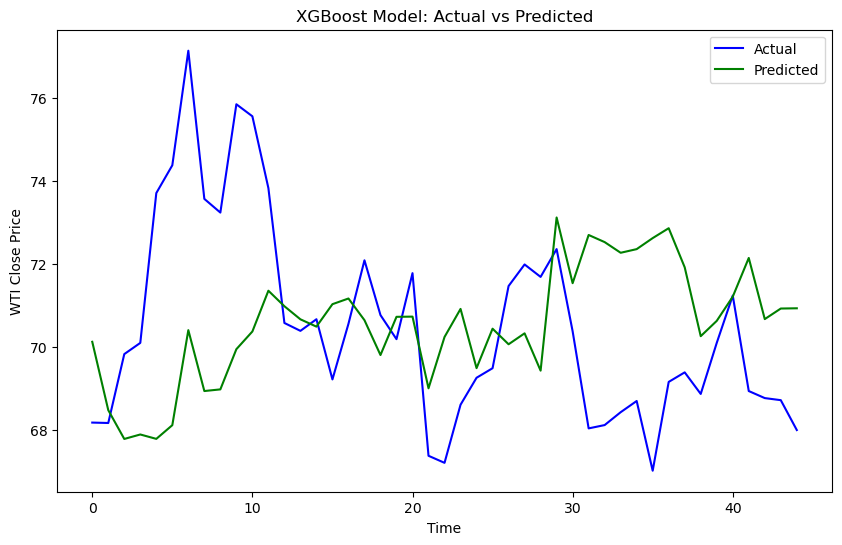

In [279]:
# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(y_test_reset, label='Actual', color='blue')
plt.plot(y_test_pred, label='Predicted', color='green')
plt.title('XGBoost Model: Actual vs Predicted')
plt.xlabel('Time')
plt.ylabel('WTI Close Price')
plt.legend()
plt.show()

### Model 3: Self-adjusted hyperparameters

In [285]:
xgb_model3 = xgb.XGBRegressor(random_state=42,max_depth=2,reg_lambda =4,
                              n_estimators =50,reg_alpha =0.1,learning_rate =0.1)

#'colsample_bytree': 0.6, 'learning_rate': 0.1, 'max_depth': 2, 
# 'n_estimators': 50, 'reg_alpha': 0.1, 'reg_lambda': 2, 'subsample': 0.9


In [286]:
xgb_model3.fit(X_train_scaled_df, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=2, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=50, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, ...)

In [287]:
cross_scores = cross_val_score(xgb_model3, X_train_scaled_df, y_train, cv=tscv, scoring='r2')
print(f"Cross-Validation R-squared scores: {cross_scores}")
print(f"Average CV R-squared: {np.mean(cross_scores):.3f}")

Cross-Validation R-squared scores: [-4.67114405e-03 -2.62853466e+01 -4.29949348e-01  2.13177243e-02
 -6.91249408e+00]
Average CV R-squared: -6.722


In [288]:
y_train_pred = xgb_model3.predict(X_train_scaled_df)
train_mse = mean_squared_error(y_train, y_train_pred)
train_rmse = np.sqrt(train_mse)
train_r2 = r2_score(y_train, y_train_pred)

y_test_pred = xgb_model3.predict(X_test_scaled_df)
test_mse = mean_squared_error(y_test, y_test_pred)
test_rmse = np.sqrt(test_mse)
test_r2 = r2_score(y_test, y_test_pred)


train_adj_r2 = adjusted_r2(train_r2, len(X_train), X_train.shape[1])
test_adj_r2 = adjusted_r2(test_r2, len(X_test), X_test.shape[1])


print(f"Model Performance (Training Set)")
print(f"-------------------------------------")
print(f"Training MSE: {round(train_mse,3)}")
print(f"Training RMSE: {round(train_rmse,3)}")
print(f"Training R-squared: {round(train_r2,3)}")
print(f"Training Adjusted R-squared: {round(train_adj_r2,3)}")

print(f"\nModel Performance (Testing Set)")
print(f"-------------------------------------")
print(f"Testing MSE: {round(test_mse,3)}")
print(f"Testing RMSE: {round(test_rmse,3)}")
print(f"Testing R-squared: {round(test_r2,3)}")
print(f"Testing Adjusted R-squared: {round(test_adj_r2,3)}")

# Overfitting
# r2_diff = train_r2 - test_r2

# if r2_diff > 0.1:
#     print(f"\n")
#     print(f"\nOverfitting Check(Based on R-squred)")
#     print(f"-------------------------------------")
#     print(f"Potential overfitting detected: Training R-squared is higher than Testing R-squared by {r2_diff:.4f}")
# else:
#     print("\nNo significant overfitting detected.")


# adj_r2_diff = train_adj_r2 - test_adj_r2

# if adj_r2_diff > 0.1:
#     print(f"\nOverfitting Check(Based on Adjustd R-squred)")
#     print(f"-------------------------------------")
#     print(f"Potential overfitting detected: Training Adjusted R-squared is higher than Testing Adjusted R-squared by {adj_r2_diff:.4f}")
# else:
#     print("\nNo significant overfitting detected.")

Model Performance (Training Set)
-------------------------------------
Training MSE: 2.599
Training RMSE: 1.612
Training R-squared: 0.86
Training Adjusted R-squared: 0.843

Model Performance (Testing Set)
-------------------------------------
Testing MSE: 10.238
Testing RMSE: 3.2
Testing R-squared: -0.796
Testing Adjusted R-squared: -1.395


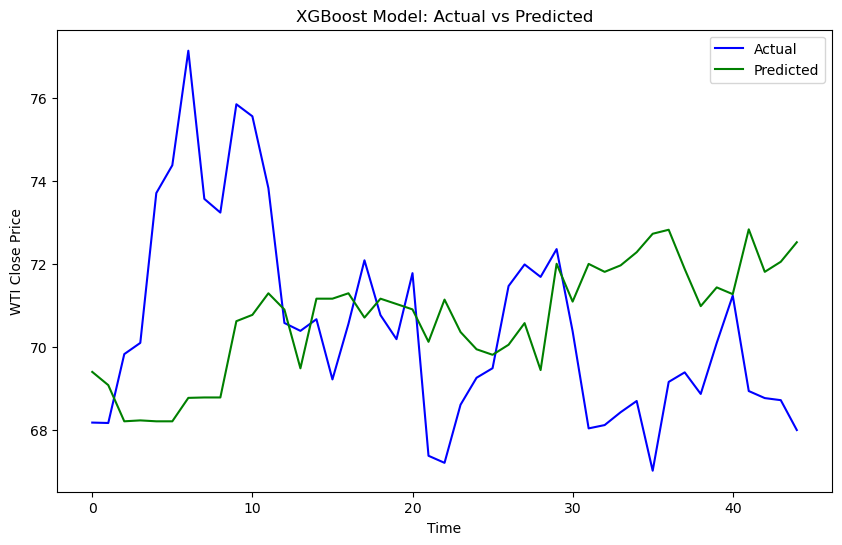

In [289]:
# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(y_test_reset, label='Actual', color='blue')
plt.plot(y_test_pred, label='Predicted', color='green')
plt.title('XGBoost Model: Actual vs Predicted')
plt.xlabel('Time')
plt.ylabel('WTI Close Price')
plt.legend()
plt.show()

In [241]:
# List the top five most important features
feature_importance_list = sorted(zip(xgb_model3.feature_importances_, X.columns), reverse=True)

for importance, feature_name in feature_importance_list[:5]:
    print(f"Feature: {feature_name}, Importance: {importance}")

Feature: day, Importance: 0.2733968496322632
Feature: volume_gold, Importance: 0.14580893516540527
Feature: ele_oil, Importance: 0.10980746150016785
Feature: usdEUR, Importance: 0.09103170037269592
Feature: month, Importance: 0.0657799020409584


### 4.3 LSTM Model

In [ ]:
# Feature selection (Same)
features = ['close_gold','volume_gold','volume_wti', 'close_ng', 'volume_ng',
       'vix', 'usdEUR', 'ele_oil', 'ele_ic',
       'month', 'day']

X = df_model[features]
y = df_model["close_wti"]

# Splitting Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle= False)

In [ ]:
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))


In [ ]:
train_data_scaled = np.hstack((X_train_scaled, y_train_scaled))
test_data_scaled = np.hstack((X_test_scaled, y_test_scaled))

In [ ]:
timesteps = 5

def create_dataset(data, timesteps=10):
    X, y = [], []
    for i in range(timesteps, len(data)):
        X.append(data[i-timesteps:i, :-1])
        y.append(data[i, -1])
    return np.array(X), np.array(y)

In [ ]:
X_train_lstm, y_train_lstm = create_dataset(train_data_scaled, timesteps)
X_test_lstm, y_test_lstm = create_dataset(test_data_scaled, timesteps)

In [ ]:
X_train_lstm = X_train_lstm.reshape((X_train_lstm.shape[0], X_train_lstm.shape[1], X_train_lstm.shape[2]))
X_test_lstm = X_test_lstm.reshape((X_test_lstm.shape[0], X_test_lstm.shape[1], X_test_lstm.shape[2]))


In [ ]:
def build_lstm_model(hp):
    model = Sequential()
    units = hp.Int('units', min_value=50, max_value=200, step=50)
    model.add(Input(shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
    model.add(LSTM(units=units, return_sequences=True))
    dropout_rate = hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.1)
    model.add(Dropout(dropout_rate))
    model.add(LSTM(units=units, return_sequences=False))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1))
    optimizer = hp.Choice('optimizer', values=['adam', 'rmsprop'])
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

tuner = kt.Hyperband(
    build_lstm_model,
    objective='val_loss',
    max_epochs=20,
    factor=3,
    directory='keras_tuner_dir',
    project_name='lstm_tuning'
)

In [ ]:
tuner.search(X_train_lstm, y_train_lstm, epochs=20, validation_data=(X_test_lstm, y_test_lstm), batch_size=32)

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"Best Units: {best_hps.get('units')}")
print(f"Best Dropout Rate: {best_hps.get('dropout_rate')}")
print(f"Best Optimizer: {best_hps.get('optimizer')}")


In [ ]:
best_model = tuner.hypermodel.build(best_hps)
history = best_model.fit(
    X_train_lstm, y_train_lstm,
    epochs=50,
    validation_data=(X_test_lstm, y_test_lstm),
    batch_size=32
)

In [ ]:
# Plot training vs validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('LSTM Model Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Evaluate the model
test_loss = best_model.evaluate(X_test_lstm, y_test_lstm)
print(f"Final Test Loss: {test_loss}")

train_loss = best_model.evaluate(X_train_lstm, y_train_lstm)
print(f"Final Train Loss: {train_loss}")


In [ ]:
y_pred_lstm = best_model.predict(X_test_lstm)


In [ ]:
y_pred_lstm_rescaled = scaler_y.inverse_transform(y_pred_lstm)
y_test_lstm_rescaled = scaler_y.inverse_transform(y_test_lstm.reshape(-1, 1))

In [ ]:
# Evaluate RMSE
rmse_lstm = np.sqrt(mean_squared_error(y_test_lstm_rescaled, y_pred_lstm_rescaled))
print(f'LSTM Model RMSE: {rmse_lstm:.4f}')


In [ ]:
# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(y_test_lstm_rescaled, label='Actual', color='blue')
plt.plot(y_pred_lstm_rescaled, label='Predicted', color='green')
plt.title('LSTM Model: Actual vs Predicted')
plt.xlabel('Time')
plt.ylabel('WTI Close Price')
plt.legend()
plt.show()